Assignment Title: Develop a Face Recognition System

Objective:

Build a face recognition system using convolutional neural networks (CNNs).
Understand the ethical implications of face recognition technologies.
Assignment Instructions:

Dataset:
Use a custom or public face dataset (e.g., LFW dataset) for training the model.
Model Implementation:
Develop a CNN-based face recognition system using the OpenCV library and TensorFlow/Keras.
Train the model to recognize faces from the dataset, and evaluate its performance.
Ethics Discussion:
Write a section in the report discussing the ethical considerations of face recognition technology, including issues of privacy, bias, and fairness.

## Import Libraries and Load Subset of Data
- Starting with subset of 15 people to experiment
- Whole Dataset is too heavy and difficult to proccess

\

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/lfw-deep-funneled



\

hub://activeloop/lfw-deep-funneled loaded successfully.



Raw name tensor: Tensor(key='name', index=Index([0]))
Name data: {'value': array([0], dtype=uint32), 'text': ['Sergio_Vieira_De_Mello']}

Available fields:
- images
- name
Selected people: ['Junichiro_Koizumi', 'Serena_Williams', 'Hugo_Chavez', 'John_Ashcroft', 'Colin_Powell', 'Tony_Blair', 'George_W_Bush', 'Ariel_Sharon', 'Jean_Chretien', 'Jacques_Chirac', 'Gerhard_Schroeder', 'Donald_Rumsfeld']


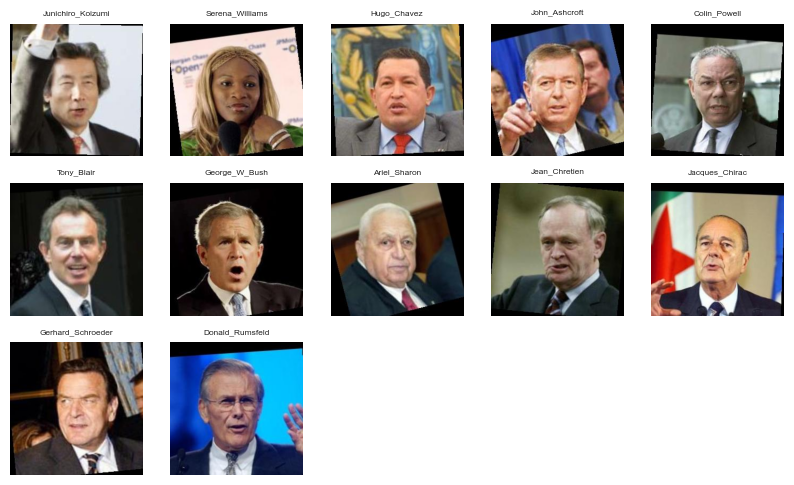

In [6]:
import deeplake
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import cv2
from sklearn.utils import shuffle

# Load a small subset of the LFW dataset
ds = deeplake.load('hub://activeloop/lfw-deep-funneled')

# Print data attributes
name = ds.name[0]  # Get first name
print("Raw name tensor:", name)
print("Name data:", name.data())  

# Show the available fields
print("\nAvailable fields:")
for field in ds.tensors:
    print(f"- {field}")

X = []  # Images
y = []  # Names

# Count occurrences per person using direct iteration to avoid integer indexing
all_counts = Counter(sample.name.data()['text'][0] for sample in ds)

# Select people with at least 50 images
eligible_people = {name for name, count in all_counts.items() if count >= 50}

person_counts = defaultdict(int)

for sample in ds:
    name_val = sample.name.data()['text'][0]

    if name_val not in eligible_people:
        continue

    if person_counts[name_val] < 70:
        image = sample.images.numpy()
        X.append(image)
        y.append(name_val)
        person_counts[name_val] += 1

print("Selected people:", list(person_counts.keys()))

# Show one image of each person and a square of their name in their face
plt.figure(figsize=(10, 10))
for i, name_val in enumerate(person_counts.keys()):
    for j in range(len(X)):
        if y[j] == name_val:
            img = X[j]
            break

    plt.subplot(5, 5, i + 1)
    plt.imshow(img)
    plt.title(name_val, fontsize=6)
    plt.axis('off')
plt.show()

# Make copy of X to try different preprocessing later
X_copy = X.copy()


## Pre Process Data

In [7]:
# Resize and normalize images using OpenCV
def preprocess_images(image):
    image = cv2.resize(image, (64, 64))  # Resize to 64x64
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Ensure correct color format
    image = image / 255.0  # Normalize to [0,1]
    return image

# Apply preprocessing to all images
X = np.array([preprocess_images(img) for img in X])

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Print dataset shapes
print("X shape:", X.shape)
print("y shape:", y.shape)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset
X, y_encoded = shuffle(X, y_encoded, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.15, random_state=42)

X shape: (762, 64, 64, 3)
y shape: (762,)


## Define & Train the Model

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.0818 - loss: 2.7762 - val_accuracy: 0.0870 - val_loss: 2.4796
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.1060 - loss: 2.4673 - val_accuracy: 0.2174 - val_loss: 2.4149
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.1590 - loss: 2.4015 - val_accuracy: 0.2348 - val_loss: 2.2675
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.2580 - loss: 2.1509 - val_accuracy: 0.3739 - val_loss: 1.9244
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.4569 - loss: 1.7790 - val_accuracy: 0.4000 - val_loss: 1.6507
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.5468 - loss: 1.4164 - val_accuracy: 0.5130 - val_loss: 1.3714
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.6368 - loss: 1.1113 - val_accuracy: 0.6435 - val_loss: 1.2714
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.7592 - loss: 0.7751 - val_accuracy: 0.6609 - v

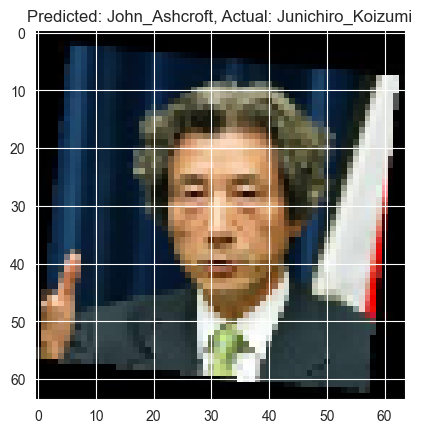

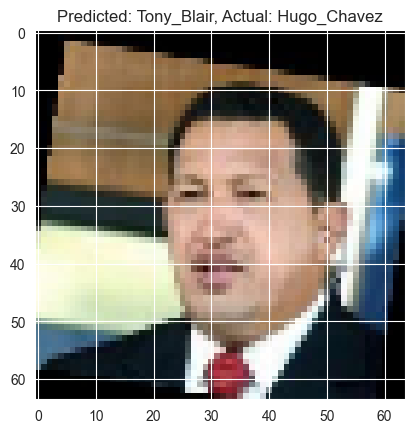

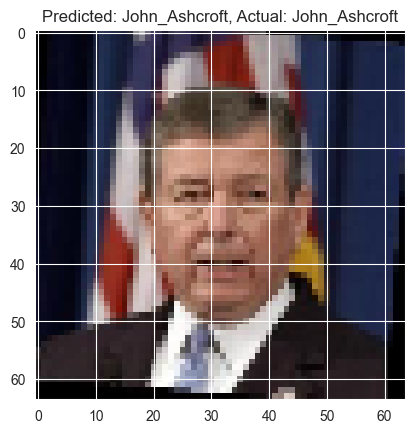

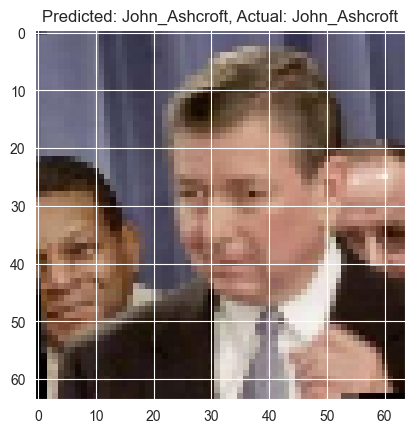

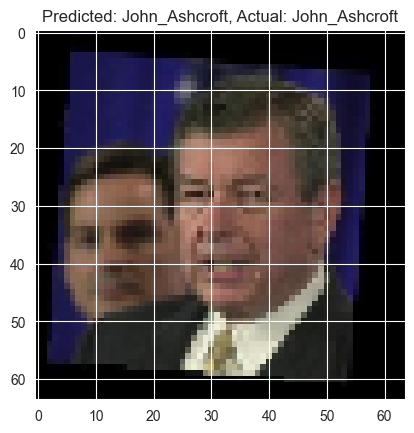

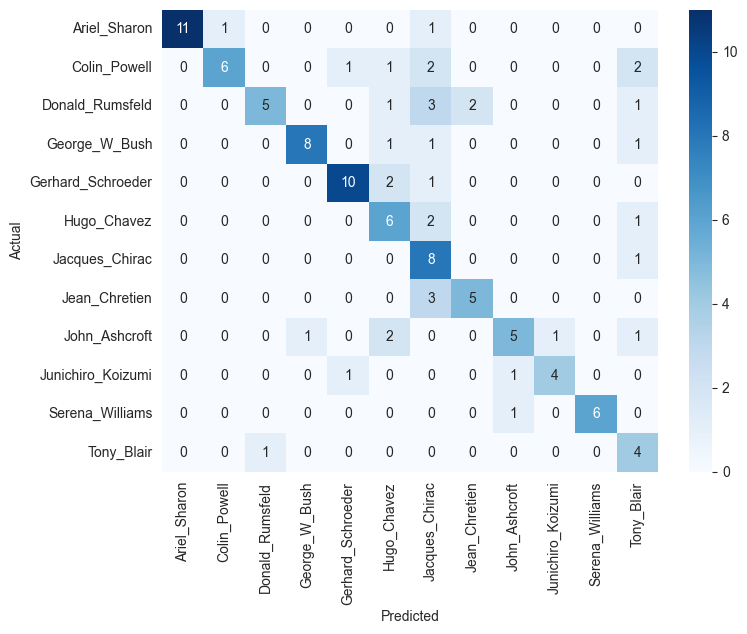

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras import models, layers
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Use 'val_accuracy' instead of 'val_acc'
    patience=5,
    restore_best_weights=True,
    mode='max'
)

# Model definition
model = models.Sequential([
    Input(shape=(64, 64, 3)),  # Define input layer explicitly
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Dropout layer

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Dropout layer

    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Dropout before the final dense layer
    Dense(len(person_counts.keys()), activation='softmax')
])

# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train model with early stopping
model.fit(X_train, y_train, 
          epochs=20, 
          batch_size=32, 
          validation_data=(X_test, y_test), 
          callbacks=[early_stopping])

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

# Save the model using the native Keras format:
model.save('face_recognition_model.keras')

# Load the model
loaded_model = tf.keras.models.load_model('face_recognition_model.keras')

# Predict using the loaded model
predictions = loaded_model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Visualize some predictions
for i in range(5):
    # Convert image from float32 (normalized) back to uint8 (0-255 range)
    img = (X_test[i] * 255).astype(np.uint8)

    # Convert BGR to RGB if needed
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img_rgb)
    plt.title(f"Predicted: {label_encoder.inverse_transform([predicted_labels[i]])[0]}, Actual: {label_encoder.inverse_transform([y_test[i]])[0]}")
    plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Test with image not in dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted: ['Jacques_Chirac']


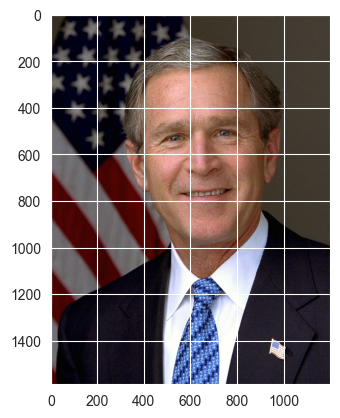

In [9]:
## Test with other images
path = "Bush.jpg"
plt.imshow(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB))

img = cv2.imread(path)
img = cv2.resize(img, (64, 64))
img = img / 255.0
img = np.expand_dims(img, axis=0)
pred = loaded_model.predict(img)
print("Predicted:", label_encoder.inverse_transform([np.argmax(pred)]))

## Analysis of Results
Currently, the model achieves an accuracy between 55-70%, which suggests that while it is learning, there is room for improvement. Some potential factors affecting performance include:
- Dataset Size & Class Imbalance: Using only 15 people with 70 images each limits the model’s generalization.
- Data Preprocessing Issues: Possible inconsistencies in image scaling and color normalization.
- Overfitting: The model may be overfitting due to a relatively small dataset.
- Hyperparameter Selection: The choice of optimizer, learning rate, batch size, and dropout rates could be further optimized.

## Experiment with different approach
# More complex data processing
## TODO


X shape: (762, 64, 64, 3)
y shape: (762,)
Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.0796 - loss: 2.5759 - val_accuracy: 0.0870 - val_loss: 2.4849
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.1116 - loss: 2.4820 - val_accuracy: 0.0435 - val_loss: 2.4870
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.1005 - loss: 2.4730 - val_accuracy: 0.0435 - val_loss: 2.4836
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.0975 - loss: 2.4748 - val_accuracy: 0.0435 - val_loss: 2.4839
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.1001 - loss: 2.4731 - val_accuracy: 0.0870 - val_loss: 2.4981
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.0971 - loss: 2.4647 - val_accuracy: 0.1391 - val_loss: 2.4843
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.1210 - loss: 2.4367 - val_accuracy: 0.0957 - val_loss: 2.5011
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.1744

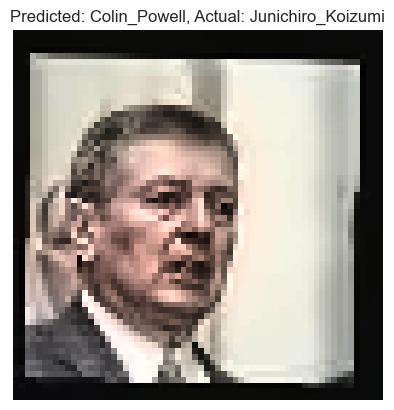

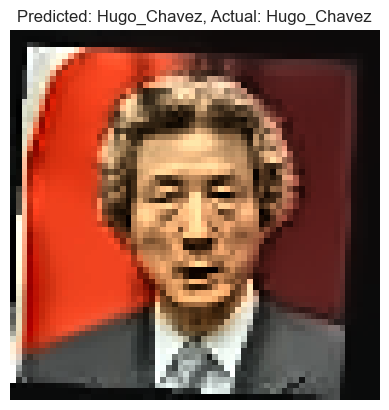

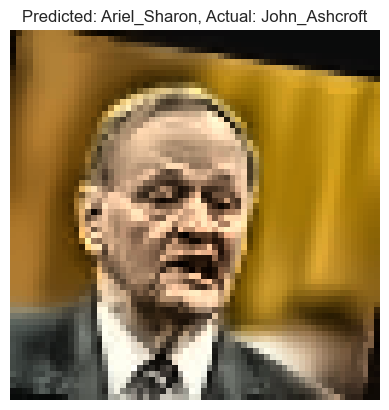

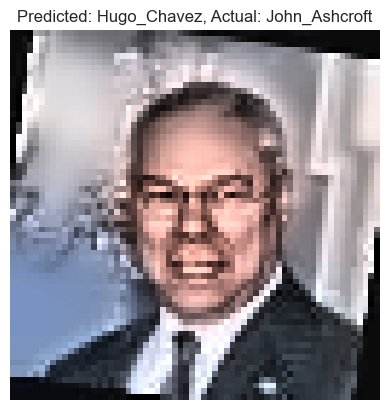

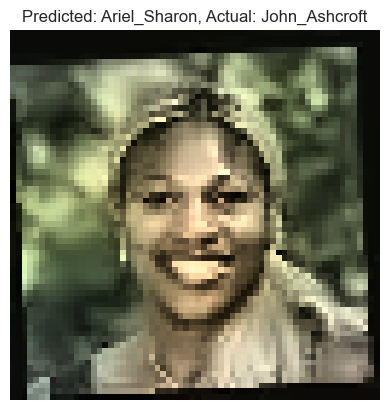

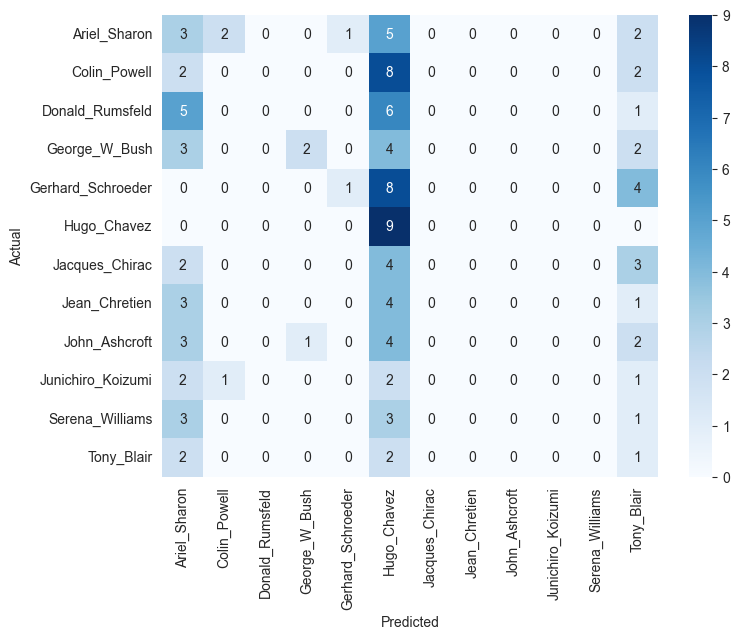

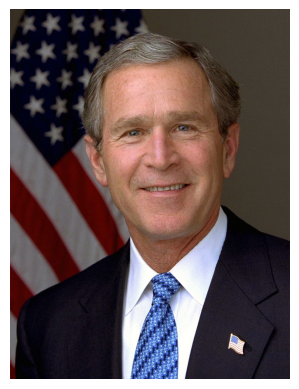

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted: ['Ariel_Sharon']


In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.layers import Input, Activation, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

# =============================================================================
# STEP 1: PREPROCESSING THE DATA
# =============================================================================
# Assume X (list/array of images) and y (list/array of corresponding labels) are defined.
# For example, you might have loaded them from a dataset:
# X, y = load_your_data()  

def enhance_preprocessing(image):
    """
    Improved image preprocessing pipeline.
    
    Steps:
    - Convert the input image to uint8 if needed.
    - Resize to 64x64.
    - Ensure the image is a 3-channel (BGR) image.
    - Convert to LAB color space and apply CLAHE on the L-channel.
    - Convert back to BGR.
    - Apply mild denoising and unsharp masking.
    - Normalize pixel values to the [0,1] range.
    
    Note: We remove per-image standardization to keep the color and contrast
          distributions consistent with what the model expects.
    """
    import cv2
    import numpy as np
    
    # Convert image to uint8 if it is in [0, 1] float format
    if image.dtype == np.float64:
        image = (image * 255).astype(np.uint8)
    
    # Resize the image to 64x64
    image = cv2.resize(image, (64, 64))
    
    # If image is grayscale, convert to 3-channel BGR
    if len(image.shape) == 2 or image.shape[2] == 1:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    # Convert from BGR to LAB color space for contrast enhancement
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to the L-channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_eq = clahe.apply(l)
    
    # Merge the equalized L-channel back with the A and B channels
    lab_eq = cv2.merge((l_eq, a, b))
    image_eq = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2BGR)
    
    # Apply mild denoising
    denoised = cv2.fastNlMeansDenoisingColored(image_eq, None, 10, 10, 7, 21)
    
    # Apply mild unsharp masking for slight sharpening
    # Here we use a smaller kernel and lower weighting to avoid over-sharpening
    gaussian = cv2.GaussianBlur(denoised, (3, 3), 0)
    enhanced = cv2.addWeighted(denoised, 1.2, gaussian, -0.2, 0)
    
    # Normalize pixel values to [0, 1]
    normalized = enhanced.astype(np.float32) / 255.0
    
    return normalized

# Apply the enhanced preprocessing to all images in X
X_processed = np.array([enhance_preprocessing(img) for img in X])
y = np.array(y)

print("X shape:", X_processed.shape)
print("y shape:", y.shape)

# Encode the string labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Shuffle and split the data into training and testing sets
X_processed, y_encoded = shuffle(X_processed, y_encoded, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_encoded, test_size=0.15, random_state=42)

# =============================================================================
# STEP 2: BUILDING THE MODEL
# =============================================================================
# If you have a dictionary of selected persons (e.g., person_counts) you might use:
# num_classes = len(person_counts.keys())
# Otherwise, we determine the number of classes from the unique labels.
num_classes = len(np.unique(y_encoded))

# Model definition
model = models.Sequential([
    Input(shape=(64, 64, 3)),  # Define input layer explicitly
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Dropout layer

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Dropout layer

    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Dropout before the final dense layer
    
    Dense(len(person_counts.keys()), activation='softmax')
])

# Compile the model using the Adam optimizer and sparse categorical cross-entropy
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# =============================================================================
# STEP 3: TRAINING THE MODEL
# =============================================================================
# Define early stopping to halt training when validation accuracy stops improving.
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Use 'val_accuracy' (or 'val_acc' for older versions)
    patience=5,
    restore_best_weights=True,
    mode='max'
)

history = model.fit(X_train, y_train, 
                    epochs=20, 
                    batch_size=32, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping])

# =============================================================================
# STEP 4: EVALUATE AND SAVE THE MODEL
# =============================================================================
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

# Save the trained model in Keras native format
model.save('face_recognition_model.keras')

# =============================================================================
# STEP 5: LOAD THE MODEL AND MAKE PREDICTIONS
# =============================================================================
loaded_model = tf.keras.models.load_model('face_recognition_model.keras')

# Make predictions on the test set
predictions = loaded_model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Visualize a few predictions from the test set
for i in range(5):
    # Convert image from float32 ([0,1] standardized) back to uint8 (0-255)
    # Note: Since the images were standardized, they might not display correctly
    # without reversing the standardization. For visualization, we will simply rescale.
    img = (X_test[i] - X_test[i].min()) / (X_test[i].max() - X_test[i].min())
    img_uint8 = (img * 255).astype(np.uint8)
    # Convert from BGR to RGB for display (enhance_preprocessing maintains BGR order)
    img_rgb = cv2.cvtColor(img_uint8, cv2.COLOR_BGR2RGB)
    
    plt.imshow(img_rgb)
    plt.title(f"Predicted: {label_encoder.inverse_transform([predicted_labels[i]])[0]}, "
              f"Actual: {label_encoder.inverse_transform([y_test[i]])[0]}")
    plt.axis('off')
    plt.show()

# Confusion matrix visualization
cm = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# =============================================================================
# STEP 6: TEST WITH A NEW IMAGE
# =============================================================================
# For example, test with an image "Bush.jpg"
path = "Bush.jpg"
img_original = cv2.imread(path)
if img_original is None:
    raise FileNotFoundError(f"Image not found at path: {path}")

# Display the original image (converted from BGR to RGB)
plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Preprocess the new image using the enhanced pipeline
img_processed = enhance_preprocessing(img_original)
img_processed = np.expand_dims(img_processed, axis=0)

# Predict the label
pred = loaded_model.predict(img_processed)
predicted_class = np.argmax(pred)
print("Predicted:", label_encoder.inverse_transform([predicted_class]))
